In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

def generate_data(N, a, sigma):
    torch.manual_seed(12345)

    mean_class1 = torch.tensor([a, a], dtype=torch.float32)
    mean_class2 = torch.tensor([-a, -a], dtype=torch.float32)
    cov_matrix = (sigma ** 2) * torch.eye(2, dtype=torch.float32)

    class1_samples = torch.distributions.MultivariateNormal(mean_class1, cov_matrix).sample((N,))
    class2_samples = torch.distributions.MultivariateNormal(mean_class2, cov_matrix).sample((N,))

    labels_class1 = torch.ones(N)
    labels_class2 = -torch.ones(N)

    X = torch.cat((class1_samples, class2_samples), dim=0)
    y = torch.cat((labels_class1, labels_class2), dim=0)

    return X, y

class Perceptron(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(2, 1)

    def forward(self, x):
        return self.linear(x)

def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1 - y_true * y_pred, min=0))

Converged at epoch 55 with weight change 0.000024
55
0.76143485
0.8567008
0.0001


<ipython-input-26-d28dc184984c>:53: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Z = np.sign(Z)


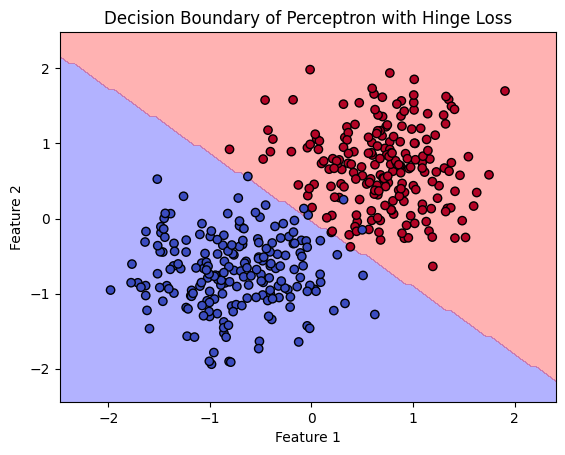

In [26]:
settings = [(0.5, 0.1), (0.5, 0.5), (0.5, 1.0), (1.0, 0.1), (1.0, 0.5), (1.0, 1.0), (2.0, 0.1), (2.0, 0.5), (2.0, 1.0)]

X_tensor, y_tensor = generate_data(200, 0.7, 0.5)

model = Perceptron()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay= 0.2)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

prev_weights = None
loss_curve = []
weight_evolution = []
tol = 1e-4

for epoch in range(10000):
    optimizer.zero_grad()
    outputs = model(X_tensor).squeeze()
    loss = hinge_loss(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      current_weights = torch.cat([p.view(-1) for p in model.parameters()])
      weight_evolution.append(current_weights.clone().cpu().numpy())
      loss_curve.append(loss.item())

      if prev_weights is not None:
        l2_norm_1 = torch.norm(current_weights, p=2)
        l2_norm_2 = torch.norm(prev_weights, p=2)

        # print(l2_norm_1)
        # print(l2_norm_2)

        weight_change = torch.abs(l2_norm_1 - l2_norm_2)

        # print(f"{current_weights}{prev_weights}{weight_change}")
        if weight_change < tol:
          print(f"Converged at epoch {epoch} with weight change {weight_change:.6f}")
          break
      prev_weights = current_weights.clone()

print(epoch)
w1, w2 = model.linear.weight.detach().numpy().flatten()
b = model.linear.bias.detach().numpy().flatten()[0]

print(w1)
print(w2)
print(tol)

x_min, x_max = X_tensor[:, 0].min() - 0.5, X_tensor[:, 0].max() + 0.5
y_min, y_max = X_tensor[:, 1].min() - 0.5, X_tensor[:, 1].max() + 0.5
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
Z = w1 * xx + w2 * yy + b
Z = np.sign(Z)

plt.contourf(xx, yy, Z, levels=1, alpha=0.3, colors=['blue', 'red'])
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y_tensor, cmap='coolwarm', edgecolors='k', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary of Perceptron with Hinge Loss')
plt.show()

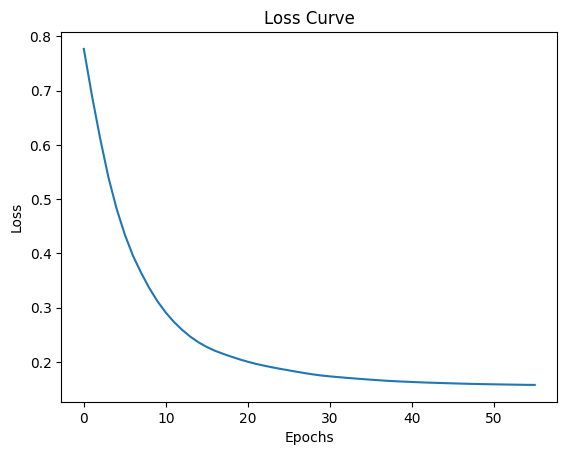

In [27]:
plt.plot(loss_curve)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

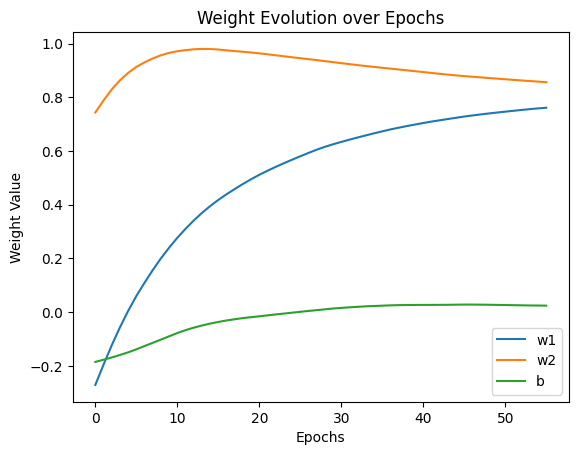

In [28]:
weight_evolution = torch.tensor(weight_evolution)
plt.plot(weight_evolution[:, 0], label="w1")
plt.plot(weight_evolution[:, 1], label="w2")
plt.plot(weight_evolution[:, 2], label="b")
plt.title("Weight Evolution over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Weight Value")
plt.legend()
plt.show()